## Use spectral Clustering to compute accuracy 

### Import data

In [1]:
import torch
import matplotlib.pyplot as plt
from models import g_step, MnistDGCCA
from dataset import get_mnist_dataset 
import numpy as np
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.cluster import KMeans, SpectralClustering


test_views, test_classes = get_mnist_dataset(train=False, normalize=False)
test_views = list(test_views)

def cluster_permutation_map(cluster_labels, real_labels, n_labels=10):
    cluster_count = []
    for i in range(n_labels):
        i_count = np.zeros(len(real_labels))
        cluster_temp = cluster_labels.copy() + 1
        
        cluster_temp[cluster_temp!=i+1] = 0
        cluster_temp[cluster_temp==i+1] = 1
        for j in range(n_labels):
            real_temp = (real_labels+1)*cluster_temp
            real_temp[real_temp!=j+1] = 0
            real_temp[real_temp==j+1] = 1
            i_count[j] = real_temp.sum()
        cluster_count.append(i_count)
    return [np.argmax(p) for p in cluster_count]

def map(cluster_labels, cluster_map, n_labels=10):
    cluster_ind = []
    mapped_labels = np.zeros(len(cluster_labels))
    for i in range(n_labels):
        cluster_ind = np.where(cluster_labels==i)
        mapped_labels[cluster_ind] = cluster_map[i]
    return mapped_labels

def delta_sum(mapped_labels, real_labels):
    a = mapped_labels - real_labels
    a[a!=0] = 1
    return len(mapped_labels) - a.sum()

def get_latent_repr(model_path, input_data):
    model = torch.load(model_path)
    out = torch.stack(model(input_data))
    return g_step(out.clone().detach())

/scratch/sagar/Projects/learn/compressai/venv/lib/python3.6/site-packages/torch/nn/functional.py:3888: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/scratch/sagar/Projects/learn/compressai/venv/lib/python3.6/site-packages/torch/nn/functional.py:3826: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


In [4]:
DGCCA_LINEAR_MNIST_PATH = 'trained_models/dgcca_mnist_linearBN11_innerit1.model'
G_linear_mnist = get_latent_repr(DGCCA_LINEAR_MNIST_PATH, test_views)
pred_linear_mnist = SpectralClustering(n_clusters=10, gamma=5, random_state=150).fit_predict(G_linear_mnist[:3000])

cluster_map = cluster_permutation_map(pred_linear_mnist, test_classes[:3000].numpy())
mapped_labels = map(pred_linear_mnist, cluster_map)
acc_linear_mnist = delta_sum(mapped_labels, test_classes[:3000].numpy())/ len(pred_linear_mnist)

acc_linear_mnist

0.862

## Linear GCCA

In [11]:
train_views, train_classes = get_mnist_dataset(train=True, normalize=False)
train_views = list(train_views)

import scipy.io as sio
data = sio.loadmat('/scratch/sagar/Projects/federated_max_var_gcca/PAMI_sim/synthetic_large/data/results/mnist_gcca.mat')

G = data['G']

pred = SpectralClustering(n_clusters=10, gamma=5, random_state=150).fit_predict(G[:3000])

cluster_map = cluster_permutation_map(pred, train_classes[:3000].numpy())
mapped_labels = map(pred, cluster_map)
acc = delta_sum(mapped_labels, train_classes[:3000].numpy())/ len(pred)

acc

/scratch/sagar/Projects/learn/compressai/venv/lib/python3.6/site-packages/torch/nn/functional.py:3888: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/scratch/sagar/Projects/learn/compressai/venv/lib/python3.6/site-packages/torch/nn/functional.py:3826: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


0.963

In [15]:
import numpy as np
from sklearn.decomposition import PCA

X = train_views[0].view(60000,-1)
pca = PCA(n_components=10)
G = pca.fit_transform(X[:5000])

pred = SpectralClustering(n_clusters=10, gamma=5, random_state=150).fit_predict(G[:3000])

cluster_map = cluster_permutation_map(pred, train_classes[:3000].numpy())
mapped_labels = map(pred, cluster_map)
acc = delta_sum(mapped_labels, train_classes[:3000].numpy())/ len(pred)

acc

KeyboardInterrupt: 

In [12]:
acc

0.5536666666666666

### Get latent representations

In [3]:
DGCCA_CONV_MNIST_PATH = 'trained_models/dgcca_mnist_ae2_shuffled.model'
DGCCA_LINEAR_MNIST_PATH = 'trained_models/dgcca_mnist_ae1_shuffled_linear.model'
DGCCA_CONV_MNIST_FED_PATH = 'trained_models/dgcca_mnist_ae2_fed.model'
DGCCA_LINEAR_MNIST_FED_PATH = 'trained_models/dgcca_mnist_linear2_fed_innerit1.model'

G_conv_mnist = get_latent_repr(DGCCA_CONV_MNIST_PATH, test_views)
G_conv_fed_mnist = get_latent_repr(DGCCA_CONV_MNIST_FED_PATH, test_views)
G_linear_mnist = get_latent_repr(DGCCA_LINEAR_MNIST_PATH, test_views)
G_linear_fed_mnist = get_latent_repr(DGCCA_LINEAR_MNIST_FED_PATH, test_views)


### Spectral clustering 

In [4]:
from sklearn.cluster import KMeans, SpectralClustering

# pred_conv_mnist = SpectralClustering(n_clusters=10, gamma=5, random_state=150).fit_predict(G_conv_mnist[:3000])
# pred_conv_fed_mnist = SpectralClustering(n_clusters=10, gamma=5, random_state=150).fit_predict(G_conv_fed_mnist[:3000])
# pred_linear_mnist = SpectralClustering(n_clusters=10, gamma=5, random_state=150).fit_predict(G_linear_mnist[:3000])
pred_linear_fed_mnist = SpectralClustering(n_clusters=10, gamma=5, random_state=150).fit_predict(G_linear_fed_mnist[:3000])


Text(0.5, 1.0, 't-SNE plot of latent representation G')

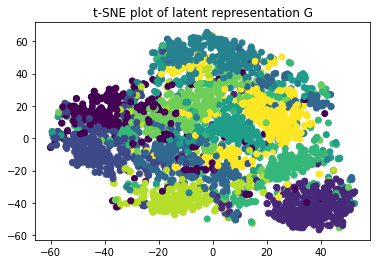

In [6]:
from sklearn.manifold import TSNE

X = G_linear_fed_mnist[:3000].numpy()
X_embedded = TSNE(n_components=2).fit_transform(X)

fig, axes = plt.subplots(1,1)

axes.scatter(X_embedded[:3000,0], X_embedded[:3000,1], c=pred_linear_fed_mnist[:3000])
axes.set_title('t-SNE plot of latent representation G')

### Compute Clustering Accuracy

In [60]:
cluster_map = cluster_permutation_map(pred_conv_mnist, test_classes[:3000].numpy())
mapped_labels = map(pred_conv_mnist, cluster_map)
acc_conv_mnist = delta_sum(mapped_labels, test_classes[:3000].numpy())/ len(pred_conv_mnist)

cluster_map = cluster_permutation_map(pred_conv_fed_mnist, test_classes[:3000].numpy())
mapped_labels = map(pred_conv_fed_mnist, cluster_map)
acc_conv_fed_mnist = delta_sum(mapped_labels, test_classes[:3000].numpy())/ len(pred_conv_fed_mnist)

cluster_map = cluster_permutation_map(pred_linear_mnist, test_classes[:3000].numpy())
mapped_labels = map(pred_linear_mnist, cluster_map)
acc_linear_mnist = delta_sum(mapped_labels, test_classes[:3000].numpy())/ len(pred_linear_mnist)

In [56]:
cluster_map = cluster_permutation_map(pred_linear_mnist, test_classes[:3000].numpy())
mapped_labels = map(pred_linear_mnist, cluster_map)

In [58]:
acc_conv_mnist = delta_sum(mapped_labels, test_classes[:3000].numpy())/ len(pred_conv_mnist)

In [59]:
acc_conv_mnist

0.9716666666666667

## TSNE for EHR data

In [ ]:
from sklearn.manifold import TSNE

X = G_linear_fed_mnist[:3000].numpy()
X_embedded = TSNE(n_components=2).fit_transform(X)

fig, axes = plt.subplots(1,1)

axes.scatter(X_embedded[:3000,0], X_embedded[:3000,1], c=pred_linear_fed_mnist[:3000])
axes.set_title('t-SNE plot of latent representation G')

In [44]:
mapped_labels

array([7., 2., 1., ..., 1., 4., 0.])

In [46]:
test_classes[:3000]

tensor([7, 2, 1,  ..., 1, 4, 0])

In [39]:
cluster_map

[2, 6, 3, 7, 4, 9, 1, 8, 5, 0]

In [21]:
a = np.array([3,3,3,0,1, 1, 1,1 ])
c = np.array([2,2,2,1,0, 0, 0, 0])

In [22]:
perm = cluster_permutation_map(c, a, n_labels=5)

In [23]:
mm = [np.argmax(p) for p in perm]

In [24]:
mm

[1, 0, 3, 0, 0]

In [23]:
test_classes[:3000]

torch.Size([10000])

In [29]:
bpred_conv_mnist[pred_conv_mnist==5].shape

(396,)

In [10]:
a.copy()

array([1, 0, 0, 1, 1, 0, 0])

In [2]:
a = np.array([2, 3, 4, 2, 2, 5, 4])

In [3]:
c = np.array([1, 3, 4, 4, 4, 5, 4])

In [4]:
a[a!=2] = 0

In [5]:
a[a==2] = 1

In [7]:
c = c*a

3

In [62]:
b = a - np.ones(len(a))*2

len(a)

3

In [66]:
a[a!=2] = 0

In [67]:
a

array([2, 0, 0, 2, 2, 0, 0])

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [47]:
b

array([-2., -1.,  0., -2., -2.,  1.,  0.])

In [41]:
4*np.array([4])

array([16])

In [39]:
len(a)*[4]

[4, 4, 4, 4, 4, 4, 4]

In [16]:
pred_conv_mnist

(3000,)